# Neo4J GDS 

https://neo4j.com/docs/graph-data-science/current/algorithms/similarity/

## Similarity

Similarity algorithms compute the similarity of pairs of nodes based on their neighborhoods or their properties. Several similarity metrics can be used to compute a similarity score. The Neo4j GDS library includes the following similarity algorithms:

Node Similarity

Filtered Node Similarity

K-Nearest Neighbors

Filtered K-Nearest Neighbors

In [1]:
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="bolt://18.234.164.187:7687",
    username="neo4j",
    password="energies-hope-fuses"
)

r = graph.query("""MATCH (n:Airport {city:"Los Angeles"}) RETURN n""")
print(r)

[{'n': {'altitude': 127, 'longest': 12091, 'color': 9, 'city': 'Los Angeles', 'coordinates': [-118.4079971, 33.94250107], 'descr': 'Los Angeles International Airport', 'iata': 'LAX', 'icao': 'KLAX', 'location': POINT(-118.4079971 33.94250107), 'pagerank_weight': 8.19355807544669, 'id': '13', 'pagerank': 8.193558075446687, 'runways': 4, 'region_airports': 1, 'country_airports': 1}}]


# Node Similarity

https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/



The Node Similarity algorithm compares a set of nodes based on the nodes they are connected to. Two nodes are considered similar if they share many of the same neighbors. Node Similarity computes pair-wise similarities based on the Jaccard metric, also known as the Jaccard Similarity Score, the Overlap coefficient, also known as the Szymkiewicz–Simpson coefficient, and the Cosine Similarity score. The first two are most frequently associated with unweighted sets, whereas Cosine with weighted input.

In [2]:
# create new  Relationship HAS_ROUTE_WEIGHT and new attribute it "weight"
# UNCOMMENT THIS CELL TO CREATE THE RELATIONSHIP HAS_ROUTE_WEIGHT if is not Created

# create a new property in Country with the count of Airports in that country
# r = graph.query("""MATCH (m:Country)
# OPTIONAL MATCH (p:Airport)-[r:IN_COUNTRY]->(m:Country)
# with  m,p, count(r) as num_airports
# set m.num_airports = num_airports
# set p.country_airports = num_airports
# return m""")
# print(len(r))

# # create a new property in Region with the count of Airports in that Region
# r = graph.query("""MATCH (m:Region)
# OPTIONAL MATCH (p:Airport)-[r:IN_REGION]->(m:Region)
# with  m,p, count(r) as num_airports
# set m.num_airports = num_airports
# set p.region_airports = num_airports
# return m""")
# print(len(r))

# # create attribute in Relationship HAS_ROUTE_WEIGHT
# """
# MATCH (p:Airport)-[r:HAS_ROUTE]->(m:Airport)
# with  r, p, m, p.region_airports as region_airports, p.country_airports as country_airports, p.runways as runways
# merge (p)-[:HAS_ROUTE_WEIGHT {weight : (region_airports* runways)/country_airports }]->(m) 

# return p limit 25
# """

In [ ]:
# Call gds.graph.drop("Graph_Airports")

In [3]:
r = graph.query("""CALL gds.graph.project(
    'Graph_Airports',
    ['Airport', 'Country'],
    {
        HAS_ROUTE_WEIGHT: {
            properties: {
                strength: {
                    property: 'runways',
                    defaultValue: 1
                }
            }
        }
    }
);""")
print(r)

[{'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {}}, 'Country': {'label': 'Country', 'properties': {}}}, 'relationshipProjection': {'HAS_ROUTE_WEIGHT': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {'strength': {'aggregation': 'DEFAULT', 'property': 'runways', 'defaultValue': 1}}, 'type': 'HAS_ROUTE_WEIGHT'}}, 'graphName': 'Graph_Airports', 'nodeCount': 3735, 'relationshipCount': 46389, 'projectMillis': 124}]


In [4]:
r[-1]

{'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {}},
  'Country': {'label': 'Country', 'properties': {}}},
 'relationshipProjection': {'HAS_ROUTE_WEIGHT': {'aggregation': 'DEFAULT',
   'orientation': 'NATURAL',
   'indexInverse': False,
   'properties': {'strength': {'aggregation': 'DEFAULT',
     'property': 'runways',
     'defaultValue': 1}},
   'type': 'HAS_ROUTE_WEIGHT'}},
 'graphName': 'Graph_Airports',
 'nodeCount': 3735,
 'relationshipCount': 46389,
 'projectMillis': 124}

In [ ]:
# We now run the Louvain algorithm to create a division of the nodes into communities that we can then evalutate.

In [5]:
r = graph.query("""CALL gds.nodeSimilarity.write.estimate('Graph_Airports', {
  writeRelationshipType: 'SIMILAR',
  writeProperty: 'score'
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory""")
print(r)

[{'nodeCount': 3735, 'relationshipCount': 46389, 'bytesMin': 1494560, 'bytesMax': 1942760, 'requiredMemory': '[1459 KiB ... 1897 KiB]'}]


# Run the algorithm in stream mode

Since we now have a community detection, we can evaluate how good it is under the conductance metric. Note that we in this case we use the feature of relationships being weighted by a relationship property.

In [9]:
# unweighted
r = graph.query("""CALL gds.nodeSimilarity.stream('Graph_Airports')
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")


In [8]:
print(r[-10:])

[{'Airport1': 'Fort Chipewyan Airport', 'Airport2': 'Denver International Airport', 'similarity': 0.004608294930875576}, {'Airport1': 'In Aménas Airport', 'Airport2': 'London Gatwick', 'similarity': 0.004291845493562232}, {'Airport1': 'Arusha Airport', 'Airport2': 'Dubai International Airport', 'similarity': 0.004048582995951417}, {'Airport1': 'Bosaso Airport', 'Airport2': 'Dubai International Airport', 'similarity': 0.004016064257028112}, {'Airport1': 'Worland Municipal Airport', 'Airport2': 'Dallas/Fort Worth International Airport', 'similarity': 0.00398406374501992}, {'Airport1': "N'Gaoundéré Airport", 'Airport2': 'Paris Charles de Gaulle', 'similarity': 0.0034129692832764505}, {'Airport1': 'Port Gentil Airport', 'Airport2': 'Paris Charles de Gaulle', 'similarity': 0.0034129692832764505}, {'Airport1': 'Salak Airport', 'Airport2': 'Paris Charles de Gaulle', 'similarity': 0.0034129692832764505}, {'Airport1': 'Arusha Airport', 'Airport2': 'Istanbul International Airport', 'similarity':

In [10]:
# unweighted
r = graph.query("""CALL gds.nodeSimilarity.stream('Graph_Airports', { topK: 3 })
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")

print(r[-10:])

[{'Airport1': 'Barcaldine Airport', 'Airport2': 'Brisbane International Airport', 'similarity': 0.012195121951219513}, {'Airport1': 'Blackall Airport', 'Airport2': 'Brisbane International Airport', 'similarity': 0.012195121951219513}, {'Airport1': 'Thief River Falls Regional Airport', 'Airport2': 'Orlando Sanford International Airport', 'similarity': 0.010526315789473684}, {'Airport1': 'Grand Canyon National Park Airport', 'Airport2': 'Phoenix Sky Harbor International Airport', 'similarity': 0.00847457627118644}, {'Airport1': 'Thief River Falls Regional Airport', 'Airport2': 'Minneapolis-St.Paul International Airport', 'similarity': 0.00641025641025641}, {'Airport1': 'Hemavan Airport', 'Airport2': 'Stockholm-Arlanda Airport', 'similarity': 0.005952380952380952}, {'Airport1': 'Grand Canyon National Park Airport', 'Airport2': 'Denver International Airport', 'similarity': 0.004629629629629629}, {'Airport1': 'Huron Regional Airport', 'Airport2': 'Denver International Airport', 'similarity'

In [11]:
# unweighted
r = graph.query("""CALL gds.nodeSimilarity.stream('Graph_Airports', { bottomK: 1 })
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")

print(r[-10:])

[{'Airport1': 'Moscow, Domodedovo International Airport', 'Airport2': 'Ronald Reagan Washington National Airport', 'similarity': 0.0030581039755351682}, {'Airport1': 'Ronald Reagan Washington National Airport', 'Airport2': 'Moscow, Domodedovo International Airport', 'similarity': 0.0030581039755351682}, {'Airport1': 'Osaka International Airport', 'Airport2': 'Istanbul International Airport', 'similarity': 0.003048780487804878}, {'Airport1': 'Afonso Pena Airport', 'Airport2': 'Istanbul International Airport', 'similarity': 0.00303951367781155}, {'Airport1': 'Denver International Airport', 'Airport2': 'Kunming Wujiaba International Airport', 'similarity': 0.0030211480362537764}, {'Airport1': 'Kunming Wujiaba International Airport', 'Airport2': 'Denver International Airport', 'similarity': 0.0030211480362537764}, {'Airport1': 'Jorge Newbery Airpark', 'Airport2': 'Istanbul International Airport', 'similarity': 0.002857142857142857}, {'Airport1': 'Charlotte County Airport', 'Airport2': 'Ist

In [ ]:
# Call gds.graph.drop("Graph_Airports")

### Filtered Node Similarity

https://neo4j.com/docs/graph-data-science/current/algorithms/filtered-node-similarity/

The Filtered Node Similarity algorithm is an extension to the Node Similarity algorithm. It adds support for filtering on source nodes, target nodes, or both.

## Node filtering
A node filter reduces the node space for which the algorithm will produce results. Consider two similarity results: A = (alice)-[:SIMILAR_TO]→(bob) and B (bob)-[:SIMILAR_TO]→(alice). Result A will be produced if the (alice) node matches the source node filter and the (bob) node matches the target node filter If the (alice) node does not match the target node filter, or the (bob) node does not match the source node filter, result B will not be produce.

In [12]:
r = graph.query("""CALL gds.graph.project(
    'Graph_Airports',
    ['Airport', 'Country', 'Region'],
    {
        HAS_ROUTE_WEIGHT: {
            properties: {
                strength: {
                    property: 'runways',
                    defaultValue: 1
                }
            }
        }
    }
);""")
print(r)

[{'nodeProjection': {'Region': {'label': 'Region', 'properties': {}}, 'Airport': {'label': 'Airport', 'properties': {}}, 'Country': {'label': 'Country', 'properties': {}}}, 'relationshipProjection': {'HAS_ROUTE_WEIGHT': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {'strength': {'aggregation': 'DEFAULT', 'property': 'runways', 'defaultValue': 1}}, 'type': 'HAS_ROUTE_WEIGHT'}}, 'graphName': 'Graph_Airports', 'nodeCount': 5262, 'relationshipCount': 46389, 'projectMillis': 161}]


# Memory Estimation 
If the results of the algorithm are as expected, the next step can be to write them back to the Neo4j database

In [18]:
r = graph.query("""CALL gds.nodeSimilarity.filtered.write.estimate('Graph_Airports', {
    writeRelationshipType: 'SIMILAR',
    writeProperty: 'score'

})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
""")

print(r)

[{'nodeCount': 5262, 'relationshipCount': 46389, 'bytesMin': 1937168, 'bytesMax': 2400224, 'requiredMemory': '[1891 KiB ... 2343 KiB]'}]


# Stream the results
In the stream execution mode, the algorithm returns the similarity score for each relationship.

In [21]:
r = graph.query("""CALL gds.nodeSimilarity.filtered.stream('Graph_Airports' )
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")



In [22]:
print(r[-10:])

[{'Airport1': 'Fort Chipewyan Airport', 'Airport2': 'Denver International Airport', 'similarity': 0.004608294930875576}, {'Airport1': 'In Aménas Airport', 'Airport2': 'London Gatwick', 'similarity': 0.004291845493562232}, {'Airport1': 'Arusha Airport', 'Airport2': 'Dubai International Airport', 'similarity': 0.004048582995951417}, {'Airport1': 'Bosaso Airport', 'Airport2': 'Dubai International Airport', 'similarity': 0.004016064257028112}, {'Airport1': 'Worland Municipal Airport', 'Airport2': 'Dallas/Fort Worth International Airport', 'similarity': 0.00398406374501992}, {'Airport1': "N'Gaoundéré Airport", 'Airport2': 'Paris Charles de Gaulle', 'similarity': 0.0034129692832764505}, {'Airport1': 'Port Gentil Airport', 'Airport2': 'Paris Charles de Gaulle', 'similarity': 0.0034129692832764505}, {'Airport1': 'Salak Airport', 'Airport2': 'Paris Charles de Gaulle', 'similarity': 0.0034129692832764505}, {'Airport1': 'Arusha Airport', 'Airport2': 'Istanbul International Airport', 'similarity':

In [ ]:
# id San Diego 8652 # sourceNodeFilter

In [23]:
r = graph.query("""CALL gds.nodeSimilarity.filtered.stream('Graph_Airports' , {sourceNodeFilter: [8652]})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")

In [24]:
r

[{'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Portland International Airport',
  'similarity': 0.5533980582524272},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Austin Bergstrom International Airport',
  'similarity': 0.5309734513274337},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Phoenix Sky Harbor International Airport',
  'similarity': 0.5230769230769231},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Seattle-Tacoma',
  'similarity': 0.5074626865671642},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Salt Lake City',
  'similarity': 0.5},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Norman Y. Mineta San Jose International Airport',
  'similarity': 0.4731182795698925},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'San Antonio',
  'similarity': 0.46808510638297873},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'New Orleans L. Armstrong',
  'similarity': 0.45454545454545453},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Kansas 

In [25]:
r = graph.query("""CALL gds.nodeSimilarity.filtered.stream('Graph_Airports' , {targetNodeFilter: [8652]})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")
r

[{'Airport1': 'Portland International Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.5533980582524272},
 {'Airport1': 'Austin Bergstrom International Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.5309734513274337},
 {'Airport1': 'Phoenix Sky Harbor International Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.5230769230769231},
 {'Airport1': 'Seattle-Tacoma',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.5074626865671642},
 {'Airport1': 'Salt Lake City',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.5},
 {'Airport1': 'Norman Y. Mineta San Jose International Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.4731182795698925},
 {'Airport1': 'San Antonio',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.46808510638297873},
 {'Airport1': 'New Orleans L. Armstrong',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.45454545454545453},
 {'Airport1': 'Kansas City International Airport',
  'Airpo

 # Delete Projection

In [26]:
r = graph.query(""" Call gds.graph.drop("Graph_Airports")
""")

print(r)

[{'graphName': 'Graph_Airports', 'database': 'neo4j', 'databaseLocation': 'local', 'memoryUsage': '', 'sizeInBytes': -1, 'nodeCount': 5262, 'relationshipCount': 46389, 'configuration': {'relationshipProjection': {'HAS_ROUTE_WEIGHT': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {'strength': {'aggregation': 'DEFAULT', 'property': 'runways', 'defaultValue': 1}}, 'type': 'HAS_ROUTE_WEIGHT'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': '4ec0a97b-6b5f-459d-8223-ff22b99f85d5', 'nodeProjection': {'Region': {'label': 'Region', 'properties': {}}, 'Airport': {'label': 'Airport', 'properties': {}}, 'Country': {'label': 'Country', 'properties': {}}}, 'logProgress': True, 'creationTime': neo4j.time.DateTime(2024, 4, 5, 14, 32, 38, 890224211, tzinfo=<UTC>), 'validateRelationships': False, 'sudo': False}, 'density': 0.001675698438868488, 'creationTime': neo4j.time.DateTime(2024, 4, 5, 14, 32, 38, 890224211, tzinfo=<UT

# K-Nearest Neighbors

https://neo4j.com/docs/graph-data-science/current/algorithms/knn/

The K-Nearest Neighbors algorithm computes a distance value for all node pairs in the graph and creates new relationships between each node and its k nearest neighbors. The distance is calculated based on node properties.

The input of this algorithm is a homogeneous graph; any node label or relationships type information in the graph is ignored. The graph does not need to be connected, in fact, existing relationships between nodes will be ignored - apart from random walk sampling if that that initial sampling option is used. New relationships are created between each node and its k nearest neighbors.

The K-Nearest Neighbors algorithm compares given properties of each node. The k nodes where these properties are most similar are the k-nearest neighbors.

The initial set of neighbors is picked at random and verified and refined in multiple iterations. The number of iterations is limited by the configuration parameter maxIterations. The algorithm may stop earlier if the neighbor lists only change by a small amount, which can be controlled by the configuration parameter deltaThreshold.

The particular implementation is based on Efficient k-nearest neighbor graph construction for generic similarity measures by Wei Dong et al. Instead of comparing every node with every other node, the algorithm selects possible neighbors based on the assumption, that the neighbors-of-neighbors of a node are most likely already the nearest one. The algorithm scales quasi-linear with respect to the node count, instead of being quadratic.

In [34]:
 # MATCH (n:Country)-[:ON_CONTINENT]->(c:Continent) RETURN n,c LIMIT 50
r = graph.query("""CALL gds.graph.project(
    'KNN',
    {
        Airport: {
            properties: ['altitude','longest','runways']
        }
    },
    '*'
);""")
print(r)

[{'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {'runways': {'property': 'runways', 'defaultValue': None}, 'altitude': {'property': 'altitude', 'defaultValue': None}, 'longest': {'property': 'longest', 'defaultValue': None}}}}, 'relationshipProjection': {'__ALL__': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {}, 'type': '*'}}, 'graphName': 'KNN', 'nodeCount': 3503, 'relationshipCount': 147447, 'projectMillis': 93}]


In [28]:
r = graph.query("""CALL gds.knn.write.estimate('KNN', {
  nodeProperties: ['altitude','longest','runways'],
  writeRelationshipType: 'SIMILAR',
  writeProperty: 'score',
  topK: 1
})
YIELD nodeCount, bytesMin, bytesMax, requiredMemory""")
print(r[:20])

[{'nodeCount': 3503, 'bytesMin': 422752, 'bytesMax': 1431712, 'requiredMemory': '[412 KiB ... 1398 KiB]'}]


In [30]:
r = graph.query("""CALL gds.knn.stream('KNN', {
    topK: 1,
    nodeProperties: ['altitude','longest','runways'],
    // The following parameters are set to produce a deterministic result
    randomSeed: 1337,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")


In [31]:
# MATCH (n:Airport) where n.descr = 'Ngari Gunsa Airport' or n.descr = 'Qamdo Bangda Airport' RETURN n LIMIT 25
r[-10:]

[{'Airport1': 'Ngari Gunsa Airport',
  'Airport2': 'Qamdo Bangda Airport',
  'similarity': 0.3351183991037739},
 {'Airport1': 'Qamdo Bangda Airport',
  'Airport2': 'Ngari Gunsa Airport',
  'similarity': 0.3351183991037739},
 {'Airport1': 'Adolfo Suarez Barajas Airport International Airport',
  'Airport2': 'Abilene Regional Airport',
  'similarity': 0.3349871007129072},
 {'Airport1': 'Cavern City Air Terminal',
  'Airport2': 'University of Illinois Willard Airport',
  'similarity': 0.33481404294801426},
 {'Airport1': 'Imam Khomeini International Airport',
  'Airport2': 'Baita International Airport',
  'similarity': 0.3348125791787764},
 {'Airport1': 'Chicago Midway International Airport',
  'Airport2': 'Tauranga Airport',
  'similarity': 0.33450463190687},
 {'Airport1': 'Pueblo Memorial Airport',
  'Airport2': 'Minneapolis-St.Paul International Airport',
  'similarity': 0.33407142706066134},
 {'Airport1': 'Las Vegas Mc Carran',
  'Airport2': 'Albuquerque International Sunport Airport',


In [32]:
# MATCH (n:Airport) where n.descr = 'Anaa Airport' or n.descr = 'Bocas Del Toro International Airport' RETURN n LIMIT 25
r[:10] 

[{'Airport1': 'Anaa Airport',
  'Airport2': 'Bocas Del Toro International Airport',
  'similarity': 1.0},
 {'Airport1': 'Anshan Air Base',
  'Airport2': 'Qinhuangdao Beidaihe Airport',
  'similarity': 1.0},
 {'Airport1': 'Baise Youjiang Airport',
  'Airport2': 'Chernobayevka Airport',
  'similarity': 1.0},
 {'Airport1': 'Bocas Del Toro International Airport',
  'Airport2': 'Anaa Airport',
  'similarity': 1.0},
 {'Airport1': 'Bogashevo Airport',
  'Airport2': 'Plovdiv International Airport',
  'similarity': 1.0},
 {'Airport1': 'Cabinda Airport',
  'Airport2': 'Syamsudin Noor Airport',
  'similarity': 1.0},
 {'Airport1': 'Chernobayevka Airport',
  'Airport2': 'Baise Youjiang Airport',
  'similarity': 1.0},
 {'Airport1': 'Chumphon Airport',
  'Airport2': 'Jorge Newbery Airpark',
  'similarity': 1.0},
 {'Airport1': 'Fort Albany Airport',
  'Airport2': 'Fort Severn Airport',
  'similarity': 1.0},
 {'Airport1': 'Fort Severn Airport',
  'Airport2': 'Fort Albany Airport',
  'similarity': 1.0}]

In [33]:
r = graph.query(""" Call gds.graph.drop("KNN")
""")

print(r)

[{'graphName': 'KNN', 'database': 'neo4j', 'databaseLocation': 'local', 'memoryUsage': '', 'sizeInBytes': -1, 'nodeCount': 3503, 'relationshipCount': 147447, 'configuration': {'relationshipProjection': {'__ALL__': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {}, 'type': '*'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': 'bf6a56a3-6e88-4df0-a268-d354b904cc49', 'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {'runways': {'property': 'runways', 'defaultValue': None}, 'altitude': {'property': 'altitude', 'defaultValue': None}, 'longest': {'property': 'longest', 'defaultValue': None}}}}, 'logProgress': True, 'creationTime': neo4j.time.DateTime(2024, 4, 5, 14, 55, 28, 545139313, tzinfo=<UTC>), 'validateRelationships': False, 'sudo': False}, 'density': 0.012019313461106112, 'creationTime': neo4j.time.DateTime(2024, 4, 5, 14, 55, 28, 545139313, tzinfo=<UTC>), 'modificationTime': neo4j.time.Date

# Filtered K-Nearest Neighbors
https://neo4j.com/docs/graph-data-science/current/algorithms/filtered-knn/

The Filtered K-Nearest Neighbors algorithm extends our popular K-Nearest Neighbors algorithm with filtering on source nodes, target nodes or both.

Types of Filtering
We are in a world of source nodes, target nodes and the relationship between them that hold a similarity score or distance.

Just like for the K-Nearest Neighbors algorithm, output with filtering are new relationships between nodes and their k-nearest neighbors. Similarity scores are expressed via relationship properties.

Filtered K-Nearest Neighbors in addition give you control over nodes on either end of the relationships, saving you from having to filter a big result set on your own, and enabling better control over output volumes.

Source node filtering
For some use cases you will want to restrict the set of nodes that can act as source nodes; or the type of node that can act as source node. This is source node filtering. You want the best scoring relationships that originate from these particular nodes or this particular type of node.

In [89]:
 # MATCH (n:Country)-[:ON_CONTINENT]->(c:Continent) RETURN n,c LIMIT 50
r = graph.query("""CALL gds.graph.project(
    'KNN',
    {
        Airport: {
            properties: ['altitude','longest','runways']
        }
    },
    '*'
);""")
print(r)

[{'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {'coordinates': {'property': 'coordinates', 'defaultValue': None}}}}, 'relationshipProjection': {'__ALL__': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {}, 'type': '*'}}, 'graphName': 'Airports', 'nodeCount': 3503, 'relationshipCount': 147447, 'projectMillis': 340}]


In [41]:
r = graph.query("""CALL gds.knn.filtered.stream('KNN', {
    topK: 3,
    nodeProperties: ['altitude','longest','runways'],
    sourceNodeFilter: 8652,
    // The following parameters are set to produce a deterministic result
    randomSeed: 1337,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")
r

[{'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Bateen Airport',
  'similarity': 0.666969696969697},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Sunan Shuofang International Airport',
  'similarity': 0.666969696969697},
 {'Airport1': 'San Diego Lindbergh',
  'Airport2': 'Martinique Aimé Césaire International Airport',
  'similarity': 0.6669002569493109}]

In [44]:
r = graph.query("""CALL gds.knn.filtered.stream('KNN', {
    topK: 3,
    nodeProperties: ['altitude','longest','runways'],
    targetNodeFilter: 8652,
    // The following parameters are set to produce a deterministic result
    randomSeed: 1337,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).descr AS Airport1, gds.util.asNode(node2).descr AS Airport2, similarity
ORDER BY similarity DESCENDING, Airport1, Airport2
""")
r[:5]

[{'Airport1': 'Bateen Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.666969696969697},
 {'Airport1': 'Sunan Shuofang International Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.666969696969697},
 {'Airport1': 'Martinique Aimé Césaire International Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.6669002569493109},
 {'Airport1': 'Taizhou Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.6668849596158045},
 {'Airport1': 'Nantong Airport',
  'Airport2': 'San Diego Lindbergh',
  'similarity': 0.6668564920273349}]

In [45]:
r = graph.query("""Call gds.graph.drop("KNN")""")
print(r)

[{'graphName': 'KNN', 'database': 'neo4j', 'databaseLocation': 'local', 'memoryUsage': '', 'sizeInBytes': -1, 'nodeCount': 3503, 'relationshipCount': 147447, 'configuration': {'relationshipProjection': {'__ALL__': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {}, 'type': '*'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': '2d7b20ea-63a9-415a-bd8a-a587826a51b8', 'nodeProjection': {'Airport': {'label': 'Airport', 'properties': {'runways': {'property': 'runways', 'defaultValue': None}, 'altitude': {'property': 'altitude', 'defaultValue': None}, 'longest': {'property': 'longest', 'defaultValue': None}}}}, 'logProgress': True, 'creationTime': neo4j.time.DateTime(2024, 4, 5, 15, 7, 27, 249646401, tzinfo=<UTC>), 'validateRelationships': False, 'sudo': False}, 'density': 0.012019313461106112, 'creationTime': neo4j.time.DateTime(2024, 4, 5, 15, 7, 27, 249646401, tzinfo=<UTC>), 'modificationTime': neo4j.time.DateTi

# Similarity functions

https://neo4j.com/docs/graph-data-science/current/algorithms/similarity-functions/
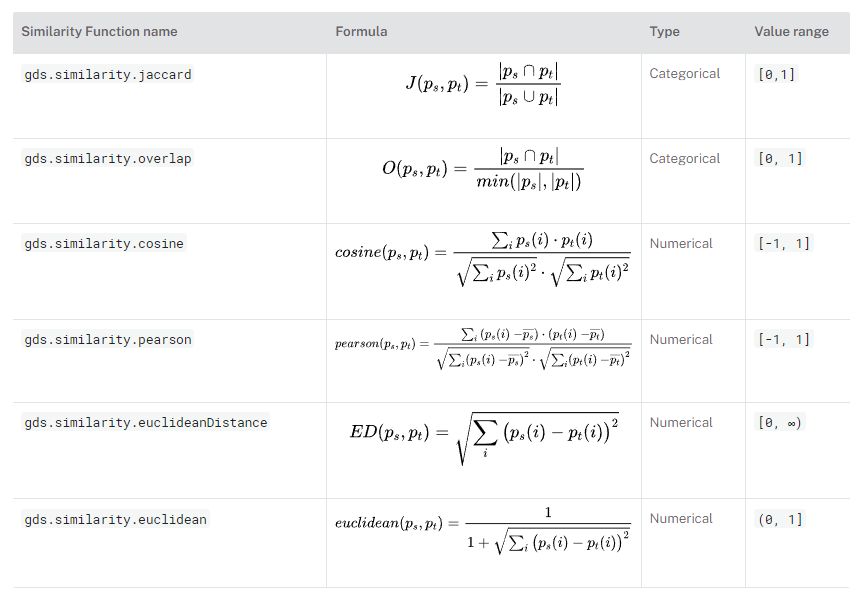nity.


In [46]:
#Jaccard similarity function
r = graph.query("""RETURN gds.similarity.jaccard(
  [1.0, 5.0, 3.0, 6.7],
  [5.0, 2.5, 3.1, 9.0]
) AS jaccardSimilarity""")
print(r)

[{'jaccardSimilarity': 0.14285714285714285}]


In [47]:
#Overlap similarity function
r = graph.query("""RETURN gds.similarity.overlap(
  [1.0, 5.0, 3.0, 6.7],
  [5.0, 2.5, 3.1, 9.0]
) AS overlapSimilarity""")
print(r)

[{'overlapSimilarity': 0.25}]


In [50]:
#Cosine similarity function
r = graph.query("""RETURN gds.similarity.pearson(
  [1.0, 5.0, 3.0, 6.7],
  [5.0, 2.5, 3.1, 9.0]
) AS pearsonSimilarity""")
print(r)

[{'pearsonSimilarity': 0.46827748364811284}]


In [51]:
#) AS overlapSimilarity""")
r = graph.query("""RETURN gds.similarity.euclideanDistance(
  [1.0, 5.0, 3.0, 6.7],
  [5.0, 2.5, 3.1, 9.0]
) AS euclideanDistance""")
print(r)

[{'euclideanDistance': 5.248809388804284}]


In [52]:
#) AS overlapSimilarity""")
r = graph.query("""RETURN gds.similarity.cosine(
  [1.0, 5.0, 3.0, 6.7],
  [5.0, 2.5, 3.1, 9.0]
) AS cosineSimilariry""")
print(r)

[{'cosineSimilariry': 0.882757381034594}]
